# Tutorial 2: Cell Embedding with C2S

In this tutorial, we will demonstrate how to perform cell embedding using the Cell2Sentence (C2S) models. Cell embeddings are crucial for downstream tasks such as clustering, visualization, and classification. By converting cells into embeddings, we create a compact representation that captures the essential information from the cell sentences.

In this tutorial, you will:
1. Load an immune tissue single-cell dataset from Domínguez Conde et al. (preprocessed in tutorial notebook 0, two sample donors), and create a CSData() wrapper around it
    - Citation: Domínguez Conde, C., et al. "Cross-tissue immune cell analysis reveals tissue-specific features in humans." Science 376.6594 (2022): eabl5197.
2. Load a pretrained C2S model and create a CSModel object.
3. Embed the cells using the C2S model.
4. Visualize the cell embeddings to gain insights into the data.

We will begin by importing the necessary libraries. These include Python's built-in libraries, third-party libraries for handling numerical computations, progress tracking, and specific libraries for single-cell RNA sequencing data and C2S operations.

In [1]:
# Python built-in libraries
import os
import random
from collections import Counter

# Third-party libraries
import numpy as np
from tqdm import tqdm

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.tasks import embed_cells

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [3]:
DATA_PATH = "/home/sr2464/palmer_scratch/C2S_Files_Syed/Cell2Sentence_Datasets/dominguez_conde_immune_tissue_two_donors_preprocessed_tutorial_0.h5ad"

In [4]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_condition_colors', 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs = adata.obs[["cell_type", "tissue", "batch_condition", "organism", "sex"]]

In [6]:
adata.obs.head()

,cell_type,tissue,batch_condition,organism,sex
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,female


In [7]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13,RP11-34P13,ENSG00000238009,38,False,38,0.001310,99.872368,39.0
RP11-34P13-3,RP11-34P13,ENSG00000241860,106,False,106,0.003627,99.643973,108.0
AP006222,AP006222,ENSG00000286448,7,False,7,0.000235,99.976489,7.0
LINC01409,LINC01409,ENSG00000237491,1292,False,1292,0.045981,95.660498,1369.0
FAM87B,FAM87B,ENSG00000177757,3,False,3,0.000101,99.989924,3.0


/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


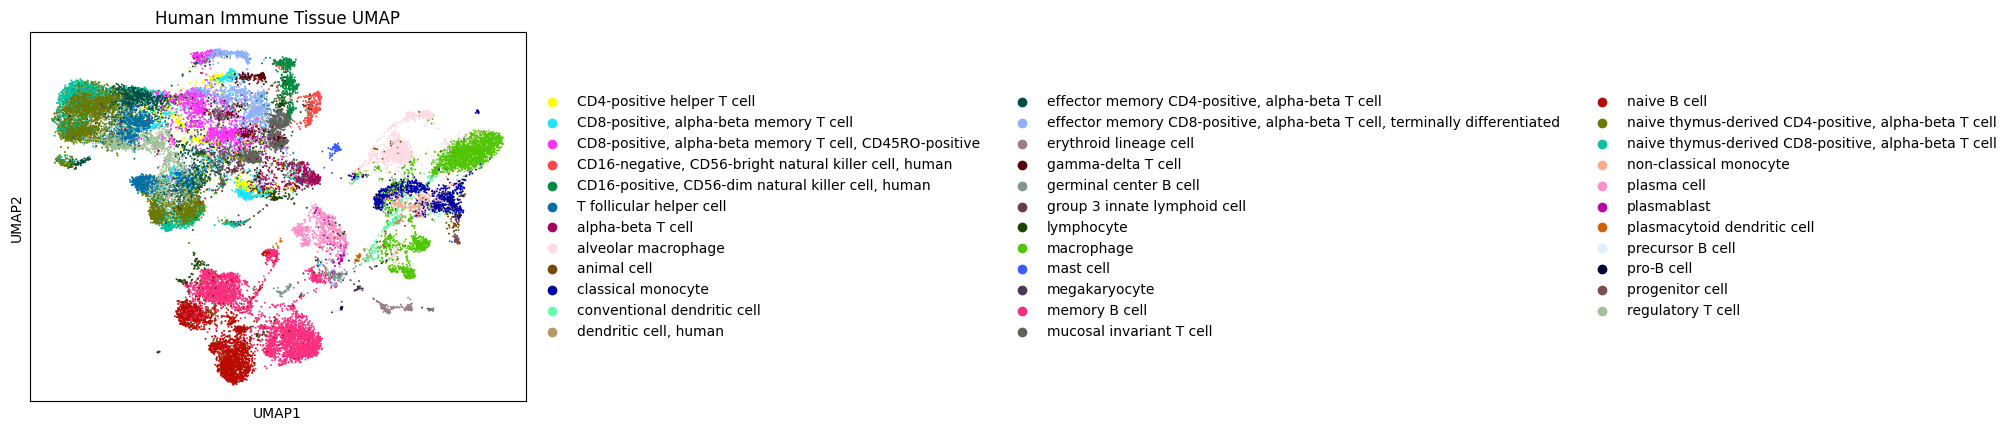

In [8]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

In [9]:
adata.X.max()

3.408124

We are expecting log10 base 10 transformed data, with a maximum value somewhere around 3 or 4. Make sure to start with processed and normalized data when doing the cell sentence conversion!

# Cell2Sentence Conversion + CSData Creation

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [10]:
adata_obs_cols_to_keep = ["cell_type", "tissue", "batch_condition", "organism", "sex"]

In [11]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 29773/29773 [00:11<00:00, 2605.40it/s]


We can visualize one sample of our created arrow dataset as follows:

In [12]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'Pan_T7935490_AAACCTGCAAATTGCC',
 'cell_sentence': 'RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14 HSP90AB1 RPL10A CXCR4 RPL4 EEF1B2 RPL36 RPS9 RPL27 NACA VIM H3-3B RPS7 HSPH1 ATP5F1E HLA-E RPL17 RPSA MYL12A RPL12 CD69 TAGAP RPL35 RPS29 RPL6 SARAF ZFP36L2 MT-ND4 ARHGDIB BTG1 RPS21 EEF1D PNRC1 EEF1G HSPA5 FYB1 CD3E IFITM1 RNASEK EEF2 MT-ND2 FTL S100A4 JUN IFITM2 CYTIP OST4 LAPTM5 RPL36AL PLAAT4 PFDN5 SAMSN1 DNAJA1 EIF4A1 FXYD5

In [13]:
c2s_save_dir = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_name = "dominguez_immune_tissue_tutorial2"  # This will be the name of our C2S dataset on disk

In [14]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 29773/29773 [00:00<00:00, 65621.10 examples/s] 


In [15]:
print(csdata)

CSData Object; Path=/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/dominguez_immune_tissue_tutorial2, Format=arrow


We can retrieve the cell sentences from our dataset using the get_sentence_strings() function of our csdata object:

In [16]:
cell_sentences_list = csdata.get_sentence_strings()

In [17]:
def print_first_N_genes(cell_sentence_str: str, top_k_genes: int, delimiter: str = " "):
    """Helper function to print K genes of a cell sentence."""
    print(delimiter.join(cell_sentence_str.split(delimiter)[:top_k_genes]))

In [18]:
print_first_N_genes(cell_sentences_list[0], top_k_genes=200)

RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14 HSP90AB1 RPL10A CXCR4 RPL4 EEF1B2 RPL36 RPS9 RPL27 NACA VIM H3-3B RPS7 HSPH1 ATP5F1E HLA-E RPL17 RPSA MYL12A RPL12 CD69 TAGAP RPL35 RPS29 RPL6 SARAF ZFP36L2 MT-ND4 ARHGDIB BTG1 RPS21 EEF1D PNRC1 EEF1G HSPA5 FYB1 CD3E IFITM1 RNASEK EEF2 MT-ND2 FTL S100A4 JUN IFITM2 CYTIP OST4 LAPTM5 RPL36AL PLAAT4 PFDN5 SAMSN1 DNAJA1 EIF4A1 FXYD5 HSPE1 CTLA4 IL32 RPL24 CFL1 SAT1 RPL13A NPM1 NDUFV2 SRSF7 ITM2B P

In [19]:
print_first_N_genes(cell_sentences_list[1], top_k_genes=200)

TMSB4X MT-CO1 B2M MT-CO2 MALAT1 HSPA1A ACTB HSP90AA1 RPLP1 MT-CO3 MT-CYB RPS27 JUNB MT-ND3 EEF1A1 HSPA1B HLA-B RPL41 RPS18 CD69 DNAJB1 JUN CCL5 RPL10 RPL28 FOS MT-ND4L MT-ATP8 RPS19 IL32 TPT1 RPL39 IFNG RPL13 FTH1 PPP1R15A RPS15A RPS14 PFN1 ZFP36 HLA-C CD52 EIF1 SH3BGRL3 PTMA MT-ATP6 RPS12 FTL ACTG1 NR4A2 RPS3 RPS15 GAPDH RPLP2 RPL11 HLA-A RPS4X TNFAIP3 RPL34 RPL18 RPL32 RPL37 RPL30 MT-ND1 RPL8 RPL19 RPS23 RPL18A MT-ND2 GZMA UBC NKG7 RPL21 RPS21 RPS27A RPS28 RPL35A GADD45B H3-3B RPS24 RPL3 RPL29 RPS6 VIM SELENOK RPLP0 S100A4 RPL26 RPS13 CD8A MTRNR2L12 RPS25 CD3E CD3D RPS7 FAU CFL1 RPL12 DUSP1 RPS8 HSPA8 RPS3A RPL9 SRSF7 RPL14 HLA-E RPL36 TRBV9 MT-ND5 RPS2 RPL27 CRIP1 ARHGDIB TMSB10 RAC2 MIF MT-ND4 H4C3 DUSP5 IER2 ZFP36L1 RPS9 MYL12A MYL6 NFKBIA RPL7A TAGLN2 RPS16 UBA52 PPIB RPS5 SERF2 RPL23A SRGN RPSA RPL24 RPL22 ATF3 PCBP2 RPL15 S100A6 PNRC1 DDIT3 RPL4 CALM1 NR4A1 TRAV4 EEF2 HOPX TPM3 ATP5F1E CORO1A CALR COTL1 UBB GZMM EVL CCL4L2 RPS29 IL2 RGS1 RPL38 CD7 SARAF HCLS1 CYBA PAXX PDCL3 AN

# Cell embedding

Now, we will embed cells using C2S. First, we need to load a pretrained C2S model which we will do cell embedding with. Any C2S model would do here for extracting embeddings, however we strongly recommend C2S models which have been trained to do cell type or tissue prediction. 

For this tutorial, we will go with the C2S-Pythia-410M cell type prediction model, which was trained to do cell type prediction on many datasets from CellxGene and Human Cell Atlas. This model will provide us with a strong LLM for obtaining cell-level embeddings, since it was trained to discriminate cell types on a diverse array of datasets and cell type annotations. More details about the C2S-Pythia-410M cell type prediction model can be found in the Model Zoo section of the ReadME in the GitHub repo, or in the Huggingface model card.

We can define our CSModel object with our pretrained cell type prediction model as follows:

In [20]:
# Define CSModel object
cell_type_prediction_model_path = "/home/sr2464/palmer_scratch/C2S_Files_Syed/multicell_pretraining_v2_important_models/pythia-410m-multicell_v2_2024-07-28_13-55-51_checkpoint-7600_cell_type_pred"
save_dir = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_2"
save_name = "cell_embedding_prediction_pythia_410M_1"
csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


In [21]:
print(csmodel)

CSModel Object; Path=/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_2/cell_embedding_prediction_pythia_410M_1


In [22]:
print(csdata)
adata.shape[0]

CSData Object; Path=/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/dominguez_immune_tissue_tutorial2, Format=arrow


29773

We will use the embed_cells() function from tasks.py to obtain cell embeddings using our C2S model. The function takes as input a CSData and CSModel objects, as well as the number of genes to use per cell sentence. It will:
1. Load the C2S model and data
2. Format the cell sentences into prompts for cell type prediction
3. Run the prompts through the C2S model
4. Collect and return cell embeddings

In [23]:
# Embed cells
embedded_cells = embed_cells(
    csdata=csdata,
    csmodel=csmodel,
    n_genes=200,
)

Reloading model from path on disk: /home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_2/cell_embedding_prediction_pythia_410M_1
Predicting cell types for 29773 cells using CSModel...


100%|██████████| 29773/29773 [21:20<00:00, 23.24it/s]


In [24]:
embedded_cells.shape

(29773, 1024)

Now, we create a UMAP of the cell embeddings to visualize the embeddings obtained from the C2S model. We will add the cell embeddings to our adata object, and rerun the neighbors and UMAP algorithms in Scanpy using the cell embeddings.

In [26]:
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp

In [27]:
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [28]:
adata.obsm["c2s_cell_embeddings"] = embedded_cells

In [29]:
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'c2s_cell_embeddings'

In [30]:
sc.pp.neighbors(adata, use_rep="c2s_cell_embeddings")  # calculate neighbors using cell embeddings

In [31]:
sc.tl.umap(adata)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


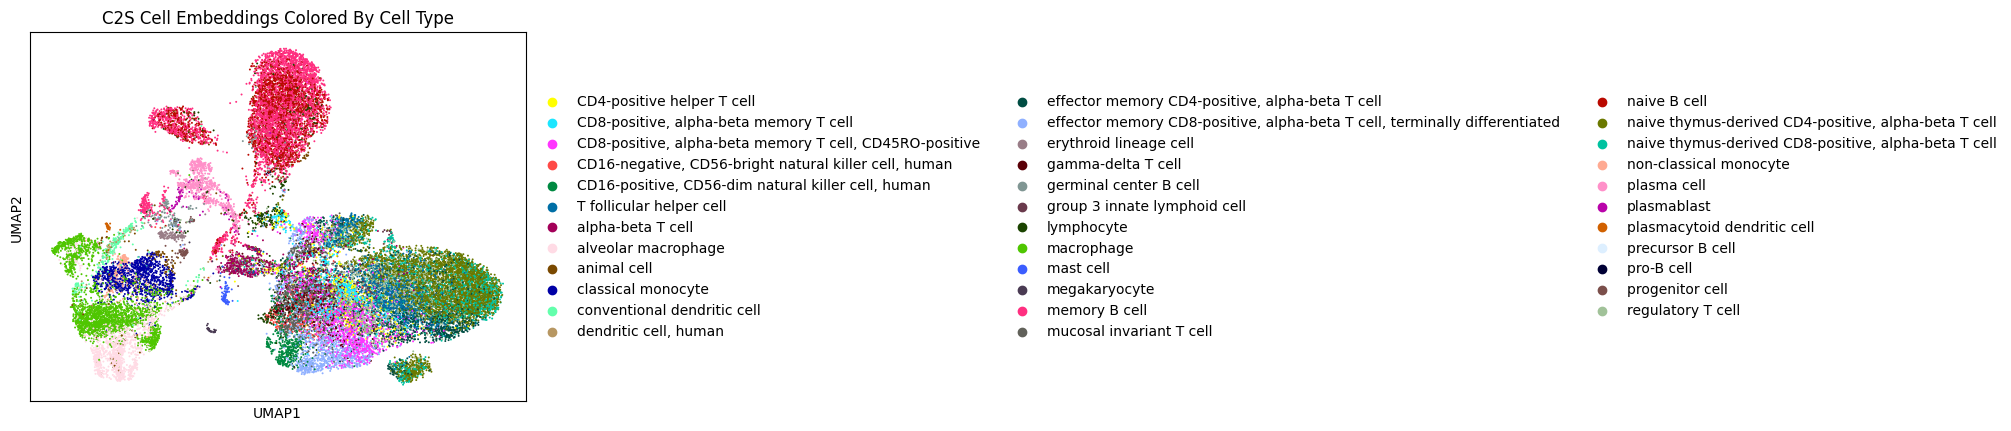

In [32]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="C2S Cell Embeddings Colored By Cell Type",
)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


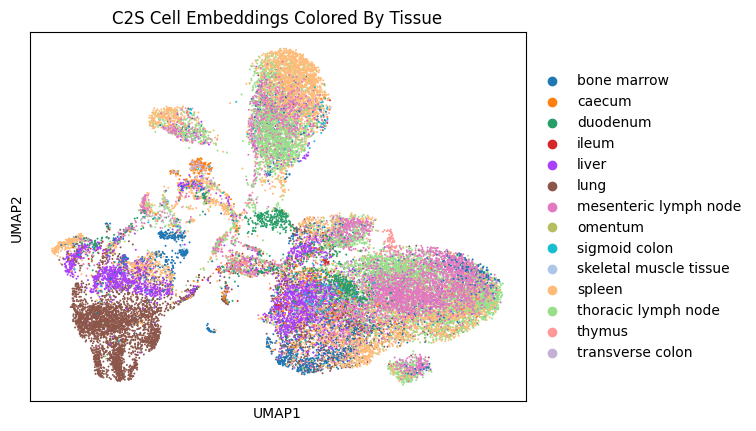

In [33]:
sc.pl.umap(
    adata,
    color="tissue",
    size=8,
    title="C2S Cell Embeddings Colored By Tissue",
)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


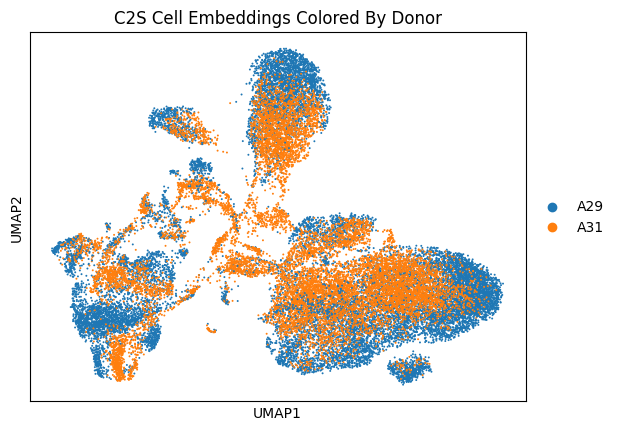

In [34]:
sc.pl.umap(
    adata,
    color="batch_condition",
    size=8,
    title="C2S Cell Embeddings Colored By Donor",
)

We can see from the UMAPs that our cell embeddings obtained from the C2S model accurately reflect the structure of the data, and retain distinct clusters separated by cell type and tissue. This is a promising sign for the embedding capability of our C2S model on single-cell datasets!